In [2]:
%config InlineBackend.figure_format = 'svg' # change output plot display format to 'svg'

# import the required modules for this notebook
import numpy
import matplotlib.pyplot as plt

# import the helper functions from the parent directory,
# these help with things like graph plotting and notebook layout
import sys
sys.path.append('..')
from helper_functions import *

# set things like fonts etc - comes from helper_functions
set_notebook_preferences()

# add a show/hide code button - also from helper_functions
toggle_code(title = "setup code")

# Heuristic approaches to the radioactive decay example

Here we investigate two heuristic approaches to the radioactive decay example. We start with a reminder of the problem.

## Example: Estimating a radioactivity decay constant

Unstable particles are emitted from a source and decay after travelling a distance $x$. The apparatus used to measure the decays can only detect them within the range $(x_{min}, x_{max})$ of the particle source. Physics tells us that $x$ follows an exponential distribution with a decay constant $\lambda$:

$$\begin{align}
p(x|\lambda) = \frac{1}{Z(\lambda)} \text{exp}\bigg(-\frac{x}{\lambda}\bigg)
\end{align}$$

where $Z(\lambda)$ is a normalisation coefficient of \\( p(x|\lambda) \\). After taking a number of measurements within the window \\((x_{min}, x_{max}) = (5, 50)\\) we end up with the dataset shown below

<div class="row">
  <div class="column">
    <img src="radio_numberline-mod.svg" alt="Snow" style="width:80%; float: center; padding: 0px; padding : 20px">
  </div>
</div>

**How can we infer the value of $\boldsymbol{\lambda}$ from these measurements**? 

We're going to begin by considering two heuristic approaches to this inference problem in order to understand what properties an "ideal" approach might have. When I ask people to suggest heuristic approaches they usually fall into two categories: those which involve computing a histogram of the data and those based around computing a statistic of the data such as the mean. Let's look at each in turn.

### **Heuristic method 1: histogram based**
 
We start by loading the dataset and plotting a histogram of the decays:

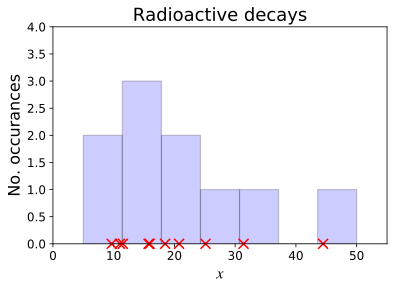

In [8]:
x = np.load('radioactive.npy') # load an array of data stored in the 'radioactive.npy' file

no_bins = 7 # how many bins to use for the histogram
plt.hist(x, no_bins, range = (5, 50), color = 'blue', zorder = 1, alpha = 0.2,
         edgecolor='black', linewidth=1.2) # plot the histogram
plot = plt.scatter(x, np.zeros_like(x), marker = 'x', color = 'red', s = 100,
                   zorder = 2, clip_on=False) # plot the decays as red crosses
beautify_plot({"title":"Radioactive decays", "x":"$x$", "y":"No. occurances"}) # from helper_functions for convenience
plt.xlim([0, 55]), plt.ylim([0, 4]) # set x, y axis limits
plt.show()

toggle_code()

Consider a bin of width $w$ located at position $x$ with limits $[x-w/2, x+w/2]$. The number of observed decay events that fall into this bin be denoted $C_{x}$. A first heuristic approach will infer $\lambda$ using these observed counts by comparing them to what we would have expected under the model. We will pick the value of $\lambda$ for which the observed and expected counts are closest. 

In order to do this, we can calculate the expected number of decays under the model, $\mathbb{E}(C_x)$, by integrating the probability density over the bin (to give us the probability that any one decay would end up in this bin) and then multiply this by the number of decays to get the expected count,

\begin{align}
\mathbb{E}(C_x) &= N \int^{x+w/2}_{x-w/2}p(x|\lambda) dx
~\approx N w p(x|\lambda) ,~~\text{ in the limit of thin bins } w \to 0\\
~\\
&= \frac{N w}{Z(\lambda)} \exp\bigg(-\frac{x}{\lambda}\bigg) \\
~\\
\log(\mathbb{E}(C_{x})) &= -\frac{x}{\lambda} + \text{const.}\\
\end{align}

Here, $N$ is the total number of decays and $p(x|\lambda)$ denotes the probability density of $x$ for a given $\lambda$. We will let $\log$ represent the natural logarithm. 

Since the relation between $\log(\mathbb{E}(C_x))$ and $x$ is linear, we can infer $\lambda$ from the slope $(-1/\lambda)$ of the best-fit line of these two quantities, using standard linear least-squares regression. The Scipy package offers the function \\(\texttt{stats.linregress}\\) which does the linear regression for us.

Slope: -0.028 Decay constant: 36.219


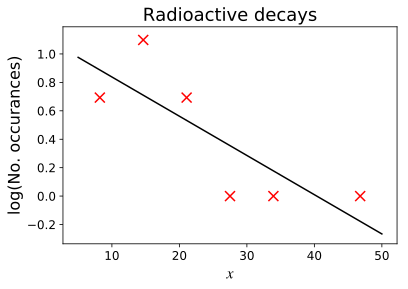

In [9]:
counts, bin_edges = np.histogram(x, no_bins, range = (5, 50)) # Count number of decays in 7 bins in the range (5, 50)
bin_midpoints = (bin_edges[:-1] + bin_edges[1:])/2 # midpoints along x-axis of the bins

selection = np.where(counts > 0)[0] # indices of the bins which have at least one decay
counts = counts[selection] # only keep bins with non-zero number of decays (otherwise the log will be -inf later)...
bin_midpoints = bin_midpoints[selection] # ... and the corresponding bin midpoints

from scipy import stats # to use least squares linear regression
slope, intercept = stats.linregress(bin_midpoints, np.log(counts))[:2] # find slope/intercept using least squares

plt.scatter(bin_midpoints, np.log(counts), marker = 'x', color = 'red', s = 100) # plot bin datapoints
plt.plot(np.linspace(5, 50, 100), slope*np.linspace(5, 50, 100) + intercept,
         color = 'black') # plot least squares line
beautify_plot({"title":"Radioactive decays", "x":"$x$", "y":"log(No. occurances)"})
print('Slope:', slope.round(3), 'Decay constant:', (-1/slope).round(3))
plt.show()

toggle_code()

There are several issues with this approach however:

- The estimated value of $\lambda$ depends on our arbitrary choice of having 7 bins. **Try changing the number of bins** to see how the inferred value of $\lambda$ changes - try values like 3, 4, 8 or 10. You should see that the decay constant strongly depends on this factor: **how many bins should we use?**


- We don't have an uncertainty estimate for $\lambda$. Would you be $100$% confident that the calculated estimate is exactly equal to the true value of $\lambda$? Probably not: since the datapoints do not lie exactly on a straight line it seems a range of values might be possible. Would you be completely certain if only two datapoints were available? **How would you go about putting error bars in the estimate of \\( \boldsymbol{\lambda}\\)?**


- Why should we use least squares regression in the first place? Least squares regression amounts to finding the slope, $m$, and intercept, $c$, which minimize the sum-of-squares error: $$\begin{align}
E = \sum^N_{n = 1} (y_n - (mx_n + c))^2
\end{align}$$ where the sum is over the N datapoints. The function $\texttt{stats.linregress}$ uses this sum-of-squares error under the hood. Why is sum-of-squares the appropriate measure of goodness-of-fit? Why not some other form of error e.g.

$$\begin{align}
E_{\text{abs}} = \sum^N_{n = 1} |y_n - (mx_n + c)|,~\text{sum of absolute errors}, or\\
~\\
E_{p} = \sum^N_{n = 1} |y_n - (mx_n + c)|^p,~\text{sum of $p$ powers of errors}?
\end{align}$$

In the next section on regression, we will show that \\(p = 2\\) can be justified in cases where Gaussian noise is corrupting the measurements, but it is difficult to justify that assmumption here. 

### Heuristic method 2: statistic based 

The first method was based on the observation that the expected histogram counts could be computed under the model and  compared to those empirically observed. The histogram counts are not the only statistics that can be simply computed under the model: why not use something simpler, like the mean of the counts. This approach would side step all of the problems associated with placing the bins.

Let's follow this approach through by first calculating the mean of the decay distribution:

\begin{align}
\mu = \mathbb{E}(x) = \int x \; p(x|\lambda) \; \text{d}x = \int x \; \frac{1}{Z(\lambda)} \text{exp}\bigg(-\frac{x}{\lambda}\bigg) \; \text{d}x
\end{align}

In order to compute this mean, we first need the normalizing constant:

\begin{align}
Z(\lambda) = \int^{x_{\text{min}}}_{x_{\text{max}}} \exp(-x/\lambda) \; \text{d}x = \lambda \left [ \exp(-x_{\text{min}}/\lambda) - \exp(-x_{\text{max}}/\lambda) \right]
\end{align}

We could compute the mean using integration by parts, but we will take the opportunity to use a neat trick that employs ['differentiation under the integral sign'](https://en.wikipedia.org/wiki/Leibniz_integral_rule). [Richard Feynman](https://en.wikipedia.org/wiki/Surely_You%27re_Joking,_Mr._Feynman!) said “it’s a certain operation... that’s not taught very much in the universities...and I used that one damn tool again and again”. It's often useful in Bayesian machine learning too:

\begin{align}
\mu  &= - \frac{1}{Z(\lambda)} \frac{\text{d} }{\text{d}(1/\lambda)} \int^{x_{\text{min}}}_{x_{\text{max}}} \exp(-x/\lambda) \; \text{d}x = - \frac{\text{d} }{\text{d}(1/\lambda)} \log Z(\lambda) \\
%
%
& = \lambda +  \frac{  
x_{\text{min}} \exp(-x_{\text{min}}/\lambda) - x_{\text{max}} \exp(-x_{\text{max}}/\lambda) 
}{\exp(-x_{\text{min}}/\lambda) - \exp(-x_{\text{max}}/\lambda)}
\end{align}

Let's sanity check this expression by considering several limits. First, consider a small decay constant, $\lambda \rightarrow 0$. In this case  we'd expect all the decays to be observed very close to $x_{\text{min}}$ and indeed $\mu \rightarrow x_{\text{min}}$. Now consider a very large decay constant, $\lambda \rightarrow 0$, in this case we'd expect a uniform distribution of observed decays and indeed $\mu \rightarrow (x_{\text{max}} + x_{\text{min}})/2$. Finally, consider a very wide detector where $x_{\text{min}}=0$ and $x_{\text{max}} \rightarrow \infty$, in this case $Z(\lambda) \rightarrow \lambda$ which is the normalising constant of the standard [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution) as expected.

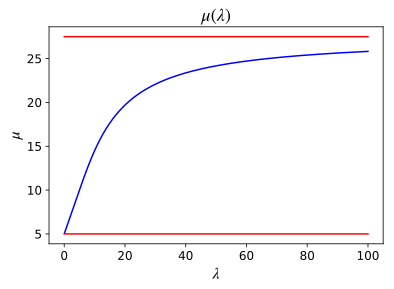

In [10]:
lamb = np.linspace(0.1, 100, 500) # values of x at which to evaluate the likelihood
xmin = 5
xmax = 50

mu = lamb + (xmin*np.exp(-xmin/lamb)-xmax*np.exp(-xmax/lamb))/(np.exp(-xmin/lamb)-np.exp(-xmax/lamb))

plt.plot(lamb, mu, color = 'blue') # plot
beautify_plot({"title":"$\mu(\lambda)$", "x":"$\lambda$", "y":'$\mu$'})

plt.plot(np.array([0,100]), np.array([xmin,xmin]), color = 'red') # plot
plt.plot(np.array([0,100]), (xmin+xmax)/2*np.array([1,1]), color = 'red') # plot

plt.show()

toggle_code()

Now consider how to use this to estimate $\lambda$. We can compute the empirical mean of the data $\hat{\mu} = \frac{1}{N} \sum_{n=1}^N x_n = \text{add computed mean here}$ and now compute the value of $\lambda$ that would result.

Emprical mean: 20.41
Estimated decay constant: 22.32


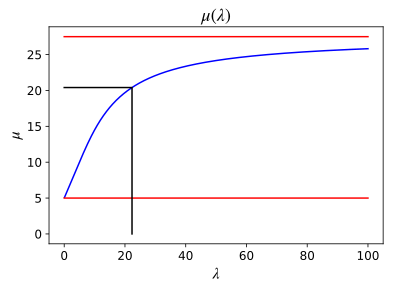

In [11]:
mn = np.mean(x)

print("Emprical mean: {}".format(mn.round(2)))


lamb_est = lamb[np.argmin(np.power(mu-mn,2))]

print("Estimated decay constant: {}".format(lamb_est.round(2)))

plt.plot(lamb, mu, color = 'blue') # plot
beautify_plot({"title":"$\mu(\lambda)$", "x":"$\lambda$", "y":'$\mu$'})

plt.plot(np.array([0,100]), np.array([xmin,xmin]), color = 'red') # plot
plt.plot(np.array([0,100]), (xmin+xmax)/2*np.array([1,1]), color = 'red') # plot
plt.plot(np.array([0,lamb_est,lamb_est]), np.array([mn,mn,0]), color = 'black') # plot


plt.show()

toggle_code()

There are several issues with this approach however:

- What should we do if the sample mean is higher than $(x_{\text{max}} - x_{\text{min}} )/2$? This could easily happen for small numbers of decays.


- Why should we choose the mean as a statistic? Why not  $\mathbb{E}(x^2) $? It turns out that the mean does have special status in this problem for reasons that become apparent when we consider the probabilistic approach.

### Summary

It is not easy to handcraft solutions to inference problems: there are often pesky hyper parameters to set; a handcrafted solution that might perform reasonably for one dataset might fail catastrophically for another; how should we chose between myriad heuristic approaches? What is needed are frameworks for supporting inference. In this [notebook](radioactive.ipynb) we apply one such framework - probabilistic inference - to the radioactive decay example.